Formation OpenClassrooms DS-IML

**Projet 2**

Par **Marc Lefèvre**, <marc.lefevre@noos.fr>

# ANALYSE DE DONNÉES EXPLORATOIRE : Open Food Facts

## 3ème Partie

# Analyses bi et multivariées

Récupération des données et chargement des bibliothèques Python que nous allons utiliser.

In [68]:
import pandas as pd
import numpy as np
import scipy.stats as st
import matplotlib.pyplot as plt
import seaborn as sns

In [69]:
df = pd.read_csv("Data/df_red2.csv")

In [70]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1442397 entries, 0 to 1442396
Data columns (total 36 columns):
code                                       1442397 non-null object
url                                        1442397 non-null object
countries_en                               1440112 non-null object
product_name                               1376880 non-null object
generic_name                               104197 non-null object
brands                                     794237 non-null object
categories                                 742846 non-null object
main_category_en                           742844 non-null object
labels                                     337050 non-null object
ingredients_text                           639422 non-null object
pnns_groups_1                              1427906 non-null object
pnns_groups_2                              1441791 non-null object
allergens                                  168321 non-null object
additives_en           

Rappelons que la justification de cette analyse exploratoire est de réfléchir sur la **faisabilité** d'un **moteur de recommandation** sur les données **Open Food Facts**.<br>Part du principe que le premier critère de recommandation de ce moteur pourrait être le **Nutriscore Grade** et que celui-ci gagnerait donc à être complétée autant que possible, nous allons particulièrement nous pencher, dans cette 3ème partie, sur la recherche de corrélations entre nos différentes variables et ce **Nutriscore Grade**.

### Energie et sel

Pour commencer, nous allons nous pencher sur les cas des deux variables concernant l'apport énergétique des aliments ('energy-kcal_100g' et "energy_100g") ainsi que sur les deux concernant la teneur en sel de ceux-ci ("salt_100g" et "sodium_100g"), dont nous allons regarder les *nuages de points* et calculer le **coefficient de corrélation** de **Pearson**.

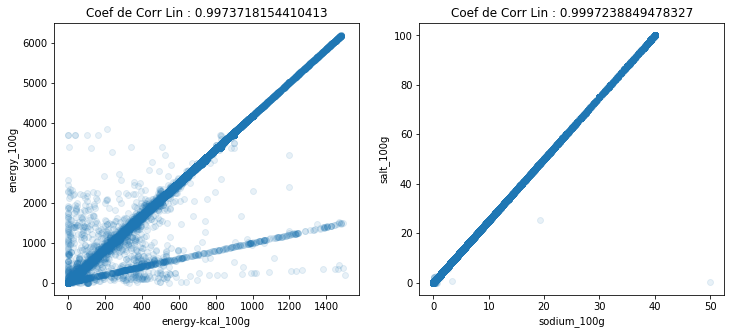

In [71]:
couples = [("energy-kcal_100g", "energy_100g"), ("sodium_100g", "salt_100g")]

i=1
plt.figure(figsize=(12,5))

# on travaille sur une restriction provisoire du set où nos variables ne sont pas nulles.
# sinon cela pose problème pour le calcul du coef. de corr. lin

for cpl in couples :
    df_p = df[(df[cpl[0]].notnull()) & (df[cpl[1]].notnull())]
    
    plt.subplot(1,2,i)
    plt.xlabel(cpl[0])
    plt.ylabel(cpl[1])
    plt.scatter(df_p[cpl[0]], df_p[cpl[1]], alpha=0.1)
    i+=1
    cp = st.pearsonr(df_p[cpl[1]], df_p[cpl[0]])[0]
    plt.title(f"Coef de Corr Lin : {cp}")
        
plt.show()

On observe dans les deux cas des corrélations presques parfaites. Nous choisissons dans chaque cas de nous séparer de la variable la moins définie des deux, c'est à dire de **"energy-kcal_100g"** et **"sodium_100g"**.

In [72]:
df = df.drop(["energy-kcal_100g", "sodium_100g"], axis=1)

### Table de corrélation

Etablissons maintenant une **table de corrélation** de nos variables quantitatives.

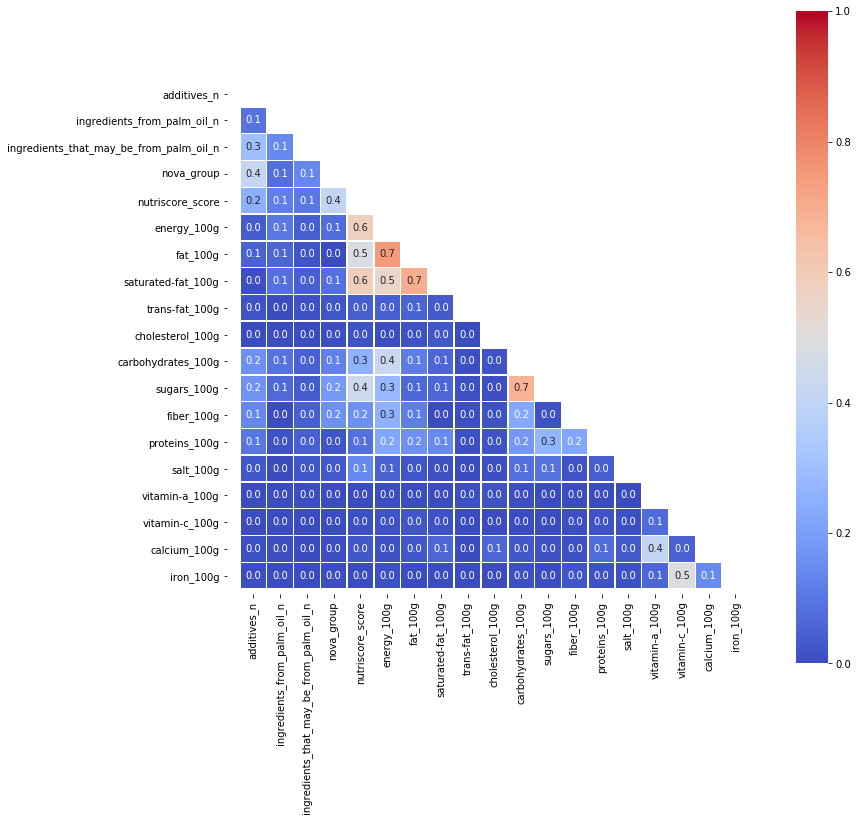

In [73]:
tab = np.abs(df[df.columns[:]].corr())

mask = np.triu(tab)

plt.figure(figsize = (12,12))
ax = sns.heatmap(tab, annot = True, fmt = ".1f", vmin = 0, vmax = 1, center = 0.5, cmap= 'coolwarm', 
            linecolor = "white", linewidth = 0.5, square = True, mask = mask)
bottom, top = ax.get_ylim()
ax.set_ylim(bottom + 0.7, top - 0.5)
left, right = ax.get_xlim()
ax.set_xlim(left - 0.5, right + 0.5)
plt.show()

On note que c'est avec les variables **energy_100g**, **fat_100g** et **satured-fat_100g** que le **nutriscore_score**, qui nous intéresse particulièrement, est le plus corrélé.<br>On note aussi quelques intéressantes corrélations entre les couples suivants :<br>- **sugars_100g** et **carbohydrates_100g**.<br>- **saturated-fat_100g** et **fat_100g**.<br>- **fat_100g** et **energy_100g**<br>Nous allons nous pencher sur elles immédiatemment, ainsi que sur le couple **trans-fat_100g** et encore **fatt_100g**.

In [74]:
couples = [("fat_100g", "energy_100g"), ("fat_100g", "saturated-fat_100g"), ("fat_100g", "trans-fat_100g"), 
           ("carbohydrates_100g", "sugars_100g")]

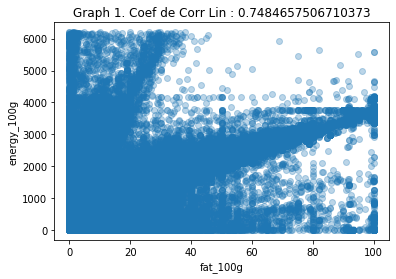

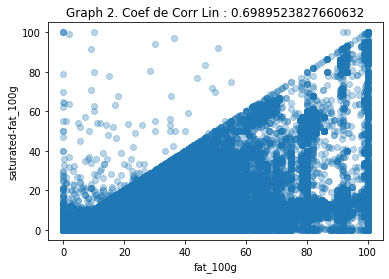

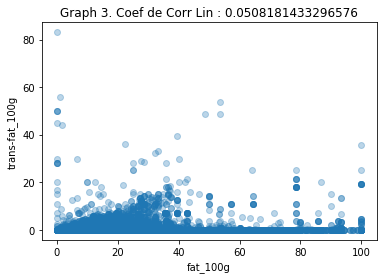

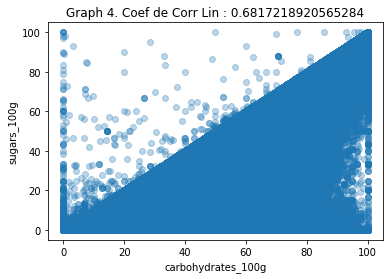

In [75]:
i=0
for cpl in couples :
    
    df_p = df[(df[cpl[0]].notnull()) & (df[cpl[1]].notnull())]
 
    plt.xlabel(cpl[0])
    plt.ylabel(cpl[1])
    plt.scatter(df_p[cpl[0]], df_p[cpl[1]], alpha=0.3)
    
    cp = st.pearsonr(df_p[cpl[1]], df_p[cpl[0]])[0]
    plt.title(f"Graph {i+1}. Coef de Corr Lin : {cp}")
    i+=1
    plt.show()

Les **graphes 2 et 4** illustrent un phénomène qu'on attendait, à savoir que les sucres (**sugars_100g**) et la graisse saturée (**saturated-fat_100g**) sont respectivement inclus dans les glucides (**carbohydrates_100g**) et le total des graisses (**fat_100g**). Il est en effet logique que des types particuliers de glucides soient inférieurs à la totalité des glucides, et qu'un type de graisse soit inférieur à la totalité des graisses.<br>C'est moins visible graphiquement, mais il en est de même dans le **graphe 3** entre les acides gras trans et les graisses (**trans-fat_100g** et **fat_100g**).<br><br>On tire principalement deus choses de cela :<br>- On va pouvoir opérer des corrections supplémentaires sur les variables **sugars_100g**, **saturated-fat_100g** et **trans-fat_100g** qui ne peuvent donc par définition pas être supérieures à respectivement **carbohydrates_100g** et **fat_100g**.<br>- Nous pourrions construire de nouvelles variables comme un **taux** de **sucres dans les glucides**, des taux de **graisse saturée** ou d'**acide gras** trans dans les **graisses**.

On applique les corrections. Cette fois, plutôt que d'éliminer les valeurs problématiques, on leur donne leur valeur théorique maximale.

In [76]:
df.loc[df["saturated-fat_100g"] > df["fat_100g"], "saturated-fat_100g" ] = df["fat_100g"]
df.loc[df["trans-fat_100g"] > df["fat_100g"], "trans-fat_100g" ] = df["fat_100g"]
df.loc[df["sugars_100g"] > df["carbohydrates_100g"], "sugars_100g" ] = df["carbohydrates_100g"]

Constructions des nouvelles variables :

In [77]:
# taux de graisse saturée dans les graisses
df["TGsat"] = df["saturated-fat_100g"] / df["fat_100g"]
# taux d'acides gras trans dans les graisses
df["TAgt"] = df["trans-fat_100g"] / df["fat_100g"]
# taux de sucres dans les glucides
df["TSu"] = df["sugars_100g"] / df["carbohydrates_100g"]

En vue de la suite, on ré-arrange l'ordre des colonnes.

In [78]:
new_order = ['code', 'url', 'countries_en', 'product_name', 'generic_name', 'brands', 'categories', 
             'main_category_en', 'labels', 'ingredients_text', 'pnns_groups_1', 'pnns_groups_2', 'allergens', 
             'additives_en', 'nova_group', 'nutriscore_score', 'nutriscore_grade', 'additives_n', 
             'ingredients_from_palm_oil_n', 'ingredients_that_may_be_from_palm_oil_n', 'energy_100g', 
             'saturated-fat_100g','TGsat', 'trans-fat_100g', 'TAgt', 'fat_100g', 'cholesterol_100g', 
             'carbohydrates_100g', 'TSu','sugars_100g', 'fiber_100g', 'proteins_100g', 'salt_100g', 
             'vitamin-a_100g', 'vitamin-c_100g', 'calcium_100g', 'iron_100g']
df = df[new_order]

## Corrélations avec le **nutriscore_grade**

Afin de détecter des corrélations entre nos variables quantitatives et le **nutriscore_grade**, corrélations qui pourrait nous être très utiles dans la création d'un modèle, nous allons observer les **boxplot** du **nutriscore_grade** en fonction de chacune de ces variables.

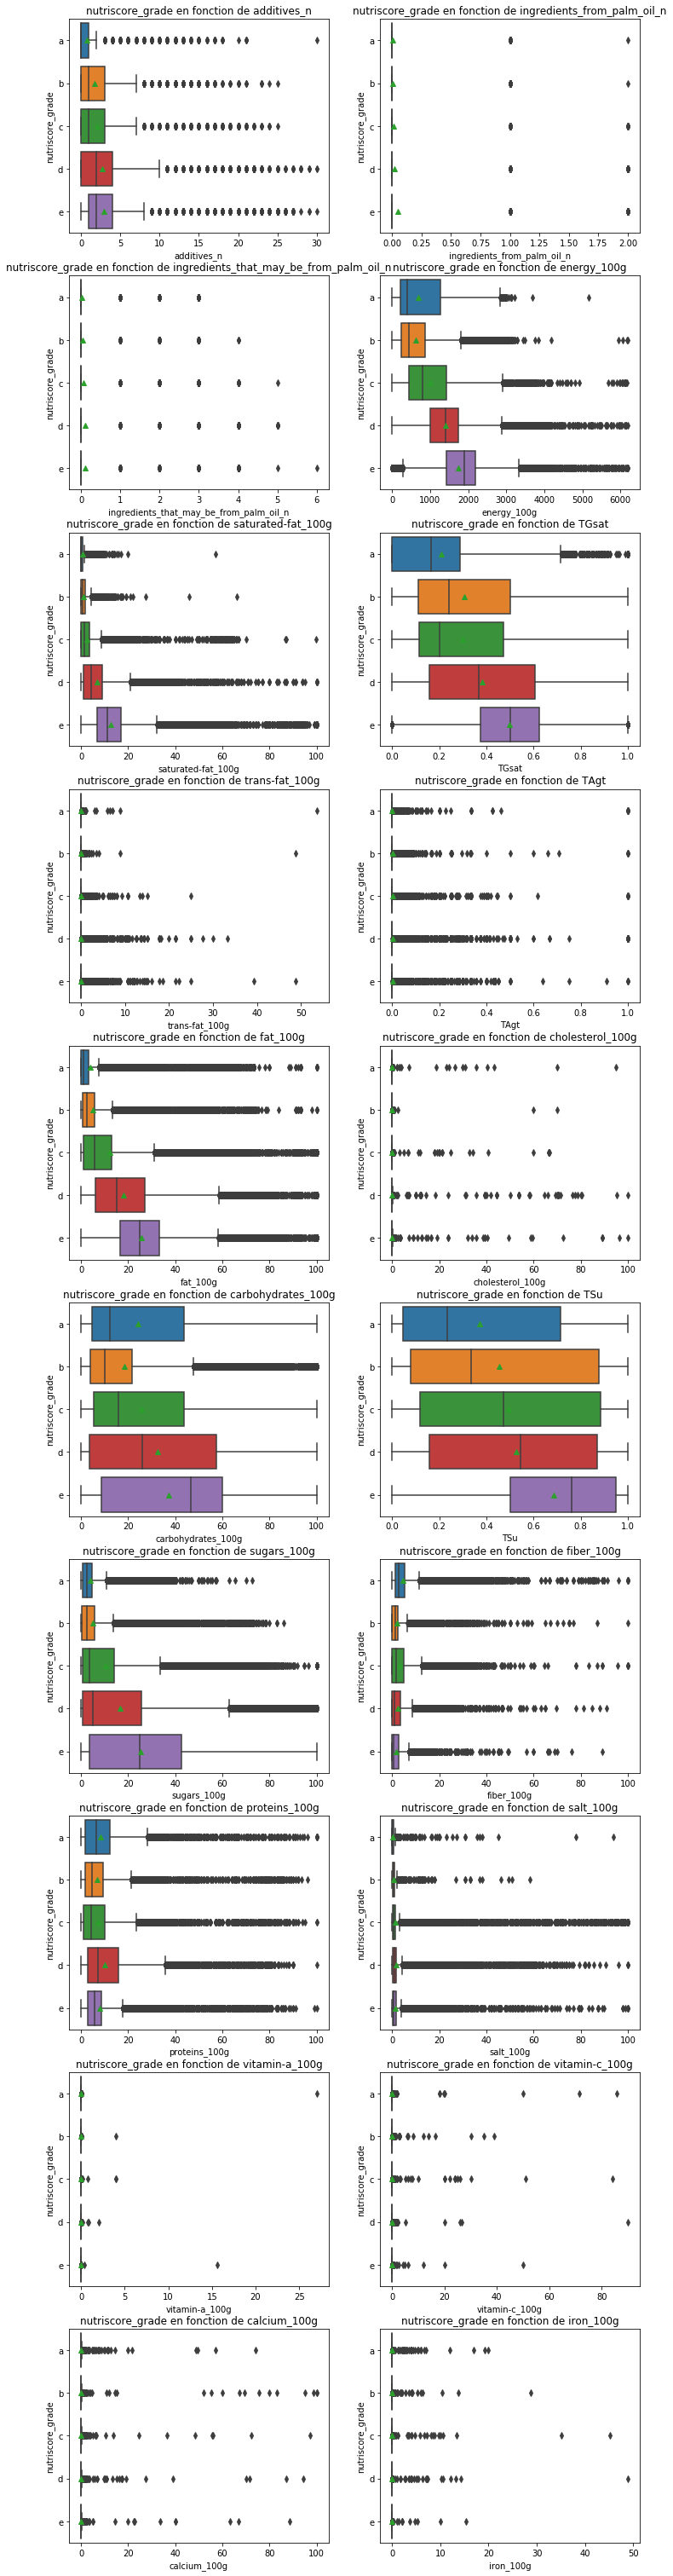

In [79]:
i = 1
plt.figure(figsize=(12, 60))
for var in df.columns[17:] :
    plt.subplot(11, 2, i)
    plt.title(f"nutriscore_grade en fonction de {var}")
    sns.boxplot(df[var], df["nutriscore_grade"].sort_values(), showmeans=True)
    i+=1

Version réduite (juste les éléments les plus probants...) du graphe donné par le code ci-dessus...

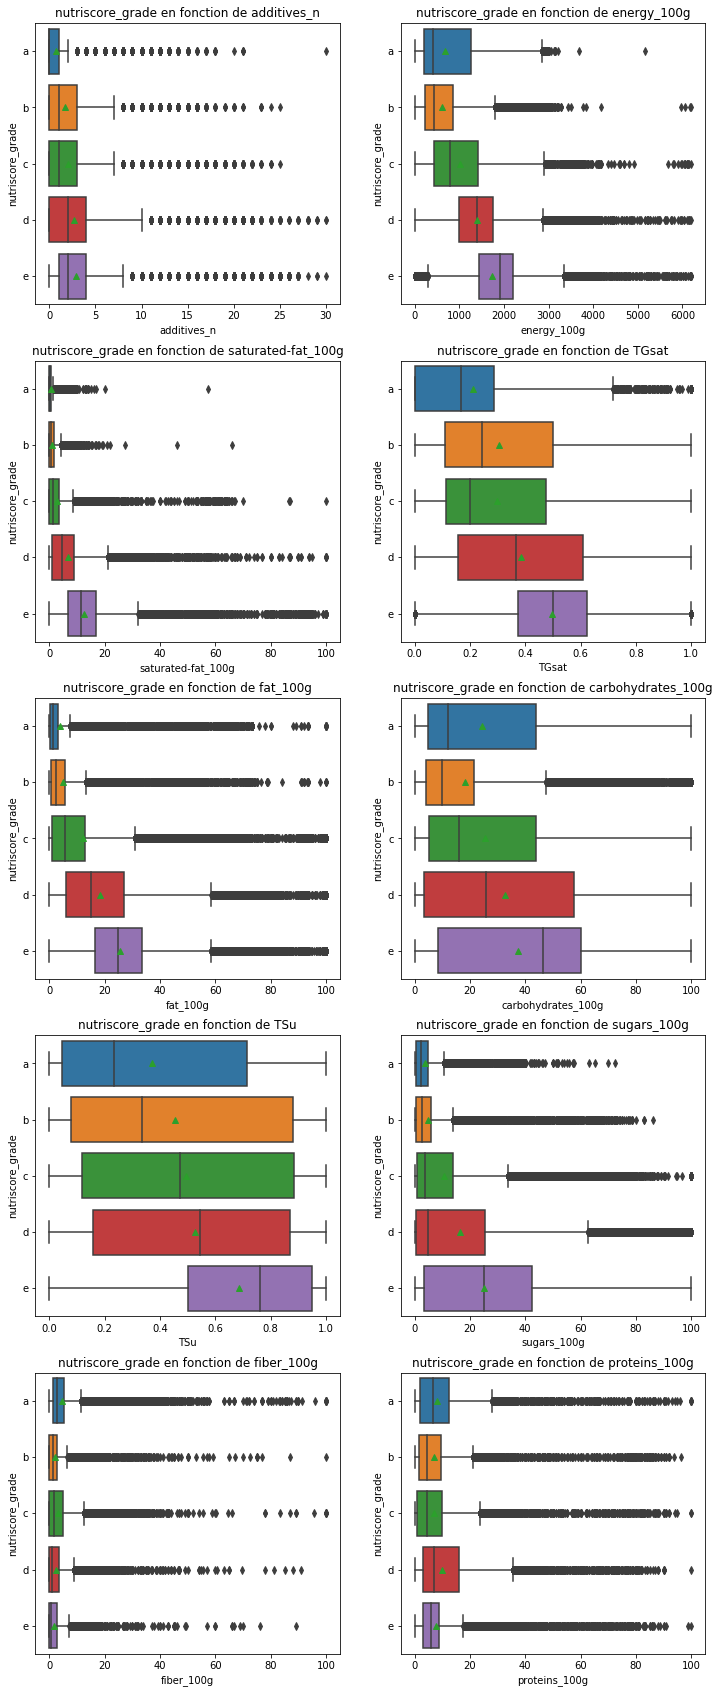

In [80]:
var_p = ['additives_n', 'energy_100g', 'saturated-fat_100g', 'TGsat', 'fat_100g', 'carbohydrates_100g', 'TSu', 
         'sugars_100g', 'fiber_100g', 'proteins_100g']

plt.figure(figsize=(12,30))
i = 1

for var in var_p :
    plt.subplot(5, 2, i)
    plt.title(f"nutriscore_grade en fonction de {var}")
    sns.boxplot(df[var], df["nutriscore_grade"].sort_values(), showmeans=True)
    i += 1
plt.show()

On remarque des éléments de corrélations intéressants, particulièrement avec les variables **additives_n**, **energy_100g**, **saturated-fat_100g**, **fat_100g**, **Tsu**, **sugar_100g**. Les autres présentent des caractères de corrélation plus diffus.<br><br>Nous pensons disposer de siffisamment d'éléments pour tenter la création d'un modèle de **classification** nous permettant de compléter la **part manquante** de la variable **nutriscore_score**.

Les deux variables **TGsat** et **TAgt** ne nous semblent pas avoir apporté d'éléments pertinents et vont être supprimées et notre dataset sauvegardé.

In [83]:
df = df.drop(["TGsat", "TAgt"], axis=1)

KeyError: "['TGsat' 'TAgt'] not found in axis"

In [84]:
df.to_csv("Data/df_mod.csv")

# Conclusion

- Nous avons considérablement diminué la surface et le poids du dataset original.
- En ayant "prévu large", c'est à dire en ayant gardé certaines variables qui nous semblent pertinentes en vue de la création de notre moteur de recommandation, quand bien-même elles ne sont que faiblement renseignées, nous disposons à présent de données **nettoyées** avec lesquelles nous pouvons poursuivre notre travail, à l'exception :
    - des variables "de référence" (code barre, etc.) que nous avons gardées en l'état.
    - des variables qualitatives "texte" dont nous gardons le traitement pourplus tard.
- Nous pensons de plus disposer des données adéquates pour tester des modèles de classification nous permettant de compléter la variable **nutriscore_grade**.

Au terme de cette analyse exploratoire du dataset **Open Food Facts**, rien ne s'oppose à la poursuite du travail sur notre **moteur de recommandation**.